# Auto Grading using Transformers

## Install all the required libraries

In [1]:
! pip install datasets
! pip install -U accelerate
! pip install -U transformers
! pip install torchinfo
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


## Import all the required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
import wandb
import math

from transformers import pipeline
from transformers import AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from pprint import pprint

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score

### Log on to weights and biases

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
torch.cuda.is_available()
torch.cuda.current_device()

0

## Loading Data

In [5]:
# Training set
df_ = pd.read_excel('/content/training_set_rel3.xlsx')
df = df_[['domain1_score', 'essay', 'essay_set']].copy()

# Validation Set complete
df_v = pd.read_excel('/content/validation_set_complete.xlsx')
df_val = df_v[['predicted_score', 'essay', 'essay_set']].copy()

# Test Set
df_t = pd.read_table('/content/test_set.tsv', delimiter='\t', encoding='mac_roman')
df_test = df_t[['essay', 'essay_set']].copy()

In [6]:
# Validation Set without labels
df_valid = pd.read_excel('/content/valid_set.xlsx')
df_val_check = df_v[['essay', 'essay_set']].copy()
df_valid.columns

Index(['essay_id', 'essay_set', 'essay', 'domain1_predictionid',
       'domain2_predictionid'],
      dtype='object')

In [7]:
# Only use Essay Set #1

df_essay1_train = df[df.essay_set == 1].copy()
df_essay1_validation = df_val[df_val.essay_set == 1].copy()
df_essay1_test = df_test[df_test.essay_set == 1].copy()

In [8]:
# Function to convert scores into classifications

def map_float_to_category(number):
    if 2 <= number <= 7:
        return 0 #low
    elif number == 8:#7 <= number <= 8:
        return 1 #medium
    elif 9 <= number <= 12:
        return 2 #high
    else:
        return 'unknown'

In [9]:
# Model validation data
df_essay1_validation['target'] = df_essay1_validation['predicted_score'].map(map_float_to_category)
df_essay1_validation

,predicted_score,essay,essay_set,target
0,7,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1,0
1,8,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1,1
2,9,"Dear Local newspaper, Have you been spending a...",1,2
3,9,"Dear Readers, @CAPS1 you imagine how life woul...",1,2
4,9,"Dear newspaper, I strongly believe that comput...",1,2
...,...,...,...,...
584,10,"Dear Newspaper, @CAPS1 of people are starting ...",1,2
585,8,"Dear @CAPS1, In this @DATE1, computors are bec...",1,1
586,5,Well I think that using computers help some pe...,1,0
587,8,"Dear @ORGANIZATION1, Some experts and some eve...",1,1


In [10]:
df_essay1_train['target'] = df_essay1_train['domain1_score'].map(map_float_to_category)
df_essay1_train

,domain1_score,essay,essay_set,target
0,8.0,"Dear local newspaper, I think effects computer...",1,1
1,9.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",1,2
2,7.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",1,0
3,10.0,"Dear Local Newspaper, @CAPS1 I have found that...",1,2
4,8.0,"Dear @LOCATION1, I know having computers has a...",1,1
...,...,...,...,...
1778,8.0,"Dear @CAPS1, @CAPS2 several reasons on way I t...",1,1
1779,7.0,Do a adults and kids spend to much time on the...,1,0
1780,8.0,My opinion is that people should have computer...,1,1
1781,2.0,"Dear readers, I think that its good and bad to...",1,0


In [11]:
df_train2 = df_essay1_train[['target', 'essay']].copy()
df_val2 = df_essay1_validation[['target', 'essay']].copy()

## Visualing data

<Axes: >

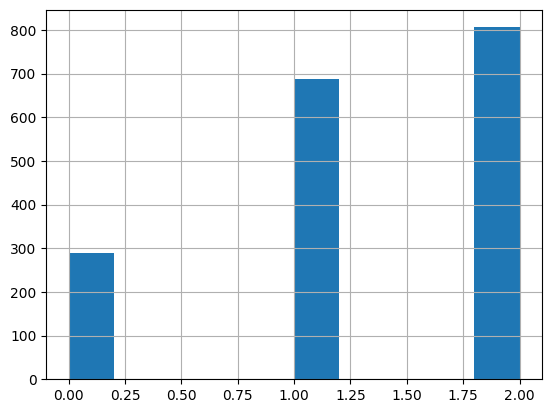

In [12]:
# Check for imbalance on the targets
df_train2['target'].hist()

In [13]:
# Prepare Train data for transformer models
df_train_final = df_train2[['essay', 'target']]
df_train_final.columns = ['sentence', 'label']
df_train_final.to_csv('train_data.csv', index=None)

# Prepare Validation data for transformer models
df_val_final = df_val2[['essay', 'target']]
df_val_final.columns = ['sentence', 'label']
df_val_final.to_csv('val_data.csv', index=None)

In [14]:
!head train_data.csv

sentence,label
"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question a

In [15]:
# For an existing train-test split:
raw_dataset = load_dataset(
    'csv',
    data_files={'train': 'train_data.csv',
                'test': 'val_data.csv'
    }
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [16]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1783
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 589
    })
})

In [17]:
raw_dataset['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

# Model Preparation

In [18]:
checkpoint = 'EleutherAI/gpt-neo-125m'

from transformers import AutoTokenizer, GPTNeoConfig, GPTNeoForSequenceClassification

# Initializing a GPT-Neo
configuration = GPTNeoConfig()

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token




(…)-125m/resolve/main/tokenizer_config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

(…)AI/gpt-neo-125m/resolve/main/config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

(…)rAI/gpt-neo-125m/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)rAI/gpt-neo-125m/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)25m/resolve/main/special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

## Unsupervised Fine tuning on Computer Sciency Wikipedia Corpus

In [19]:
# Wiki Fine tuning dataset
tune_dataset = load_dataset('text', data_files='/content/cs_file.txt')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
tune_dataset.shape

{'train': (169995, 1)}

In [21]:
wiki_dataset = tune_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [22]:
wiki_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 118996
    })
    test: Dataset({
        features: ['text'],
        num_rows: 50999
    })
})

In [23]:
from datasets import ClassLabel
import random
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [24]:
show_random_elements(wiki_dataset["train"])

,text
0,
1,
2,"A measure on a set is a systematic way to assign a number to each suitable subset of that set, intuitively interpreted as its size. In this sense, a measure is a generalization of the concepts of length, area, and volume. A particularly important example is the Lebesgue measure on a Euclidean space, which assigns the conventional length, area, and volume of Euclidean geometry to suitable subsets of the"
3,
4,== U ==
5,0
6,
7,"In 1976, John Murphy of Datapoint Corporation created ARCNET, a token-passing network first used to share storage devices."
8,
9,c


In [25]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [26]:
tokenized_data = wiki_dataset.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/118996 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50999 [00:00<?, ? examples/s]

In [27]:
# block_size = tokenizer.model_max_length
block_size = 128

In [28]:
#  Preprocessing function that will group our texts:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [29]:
lm_datasets = tokenized_data.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/118996 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50999 [00:00<?, ? examples/s]

In [30]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18626
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8050
    })
})

In [31]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' use those resources elsewhere. Again, ideal risk management minimizes spending (or manpower or other resources) and also minimizes the negative effects of risks.A unit of energy equal to approximately 1.6×10−19 joule. By definition, it is the amount of energy gained by the charge of a single electron moved across an electric potential difference of one volt.Virtual reality                    {\\displaystyle {\\ce {HA <=> H+ + A-}}}        A computer system intended to converse with a'

In [32]:
# Initializing a model

from transformers import AutoModelForCausalLM
wiki_model = AutoModelForCausalLM.from_pretrained(checkpoint)

wiki_model.config.pad_token_id = wiki_model.config.eos_token_id

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [33]:
model_name = checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-wikitext",
    report_to="wandb",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    # push_to_hub=True,
)

In [34]:
wiki_trainer = Trainer(
    model=wiki_model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    tokenizer=tokenizer,
)

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
wiki_trainer.train()

wandb: Currently logged in as: 2468512. Use `wandb login --relogin` to force relogin


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,3.195800,3.187575
2,3.046300,3.155037
3,2.958900,3.149693


TrainOutput(global_step=6987, training_loss=3.0803797279490035, metrics={'train_runtime': 998.4475, 'train_samples_per_second': 55.965, 'train_steps_per_second': 6.998, 'total_flos': 3648932546347008.0, 'train_loss': 3.0803797279490035, 'epoch': 3.0})

In [37]:
# Check Perplexity
eval_results = wiki_trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 23.33


In [38]:
wiki_trainer.save_model('wiki_model')


## Prepare supervised training data

In [39]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], padding='max_length', truncation=True, return_tensors="pt")

In [40]:
tokenized_datasets = raw_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1783 [00:00<?, ? examples/s]

Map:   0%|          | 0/589 [00:00<?, ? examples/s]

In [41]:
# dir(tokenized_datasets)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1783
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 589
    })
})

## Initialising model

In [42]:
model = GPTNeoForSequenceClassification(configuration).from_pretrained(checkpoint, num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
GPTNeoForSequenceClassification                         --
├─GPTNeoModel: 1-1                                      --
│    └─Embedding: 2-1                                   38,597,376
│    └─Embedding: 2-2                                   1,572,864
│    └─Dropout: 2-3                                     --
│    └─ModuleList: 2-4                                  --
│    │    └─GPTNeoBlock: 3-1                            7,085,568
│    │    └─GPTNeoBlock: 3-2                            7,085,568
│    │    └─GPTNeoBlock: 3-3                            7,085,568
│    │    └─GPTNeoBlock: 3-4                            7,085,568
│    │    └─GPTNeoBlock: 3-5                            7,085,568
│    │    └─GPTNeoBlock: 3-6                            7,085,568
│    │    └─GPTNeoBlock: 3-7                            7,085,568
│    │    └─GPTNeoBlock: 3-8                            7,085,568
│    │    └─GPTNeoBlock: 3-9           

## Training and parameter tuning

In [44]:
training_args = TrainingArguments(
  # report_to='none',
  report_to="wandb",
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=5,
  learning_rate=1e-4,
  weight_decay=0.01,
  load_best_model_at_end = True,
  per_device_train_batch_size=2,
  per_device_eval_batch_size=4,
)

In [45]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [46]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [47]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [48]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.164400,0.742538,0.706282,0.670093
2,1.205000,0.726390,0.711375,0.513265
3,0.977700,0.786772,0.724958,0.662299
4,1.060900,0.598235,0.758913,0.709116
5,0.878100,0.637122,0.762309,0.722010


TrainOutput(global_step=4460, training_loss=1.0488098691931755, metrics={'train_runtime': 1996.6509, 'train_samples_per_second': 4.465, 'train_steps_per_second': 2.234, 'total_flos': 9314897488773120.0, 'train_loss': 1.0488098691931755, 'epoch': 5.0})

In [49]:
wandb.finish()

eval/accuracy,▁▂▃██
eval/f1,▆▁▆██
eval/loss,████▁▁▂▁▁
eval/runtime,▁▁▁▁██▇▇▇
eval/samples_per_second,████▁▁▁▁▁
eval/steps_per_second,████▁▁▁▁▁
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▂▂▂▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇███▁▁▂▂▂▃▃▃▄▄▄▅▅▅
train/learning_rate,▂▂▂▂▂▂▂▂▁▁▁▁▁█▇▆▅▄▄▃▂
train/loss,████▇▇▇▇▇▇▇▇▇▂▁▂▁▁▂▂▁
train/total_flos,▁█


In [50]:
!ls training_dir

checkpoint-1784  checkpoint-2676  checkpoint-3568  checkpoint-4460  checkpoint-892


In [51]:
trainer.save_model('my_saved_model')

In [52]:
!ls my_saved_model

config.json  model.safetensors	      tokenizer_config.json  training_args.bin
merges.txt   special_tokens_map.json  tokenizer.json	     vocab.json


## Testing the saved Model

### Prepare Test Data

In [53]:
df__= pd.read_csv('/content/test_Predicted_scores.csv')
df_essay1_test['score'] = df__['predicted_score']

df_essay1_test['target'] = df_essay1_test['score'].map(map_float_to_category)
df_test = df_essay1_test[['essay', 'target']].copy()

df_test.columns = ['sentence', 'label']
df_test.to_csv('test_data.csv', index=None)

test_dataset = load_dataset('csv', data_files='test_data.csv')
test_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 594
    })
})

In [54]:
# Function to convert labels to integers
def get_label(d):
  return int(d['label'].split('_')[1])


### Test Baseline Model

In [119]:
rawmodel = pipeline('text-classification',  model ='EleutherAI/gpt-neo-125m', device=0)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
test_pred = rawmodel(valid_data['test']['sentence'])

In [121]:
test_pred = [get_label(d) for d in test_pred]

In [122]:
print("acc:", accuracy_score(valid_data['test']['label'], test_pred))

acc: 0.30601092896174864


In [123]:
print("f1:", f1_score(valid_data['test']['label'], test_pred, average='macro'))

f1: 0.2245156365471389


In [124]:
# Calculate QWK
qwk_score = cohen_kappa_score(valid_data['test']['label'], test_pred, weights='quadratic')
print("Quadratic Weighted Kappa Score:", qwk_score)

Quadratic Weighted Kappa Score: -0.03416659958234103


In [132]:
# The Confusion Matrix
# def plot_cm(cm):
#   classes = ['low', 'medium', 'high']
#   df_cm = pd.DataFrame(cm, index=classes, columns=classes)
#   ax = sn.heatmap(df_cm, annot=True, fmt='g')
#   ax.set_xlabel("Predicted")
#   ax.set_ylabel("Target")

# cm = confusion_matrix(valid_data['test']['label'], test_pred, normalize='true')
# plot_cm(cm)

### Test Fine tuned wiki model

In [115]:
unsupervised = pipeline('text-classification', model='wiki_model', device=0)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at wiki_model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [116]:
test_preds = unsupervised(valid_data['test']['sentence'])

In [125]:
test_preds[0]

{'label': 'LABEL_0', 'score': 0.8940008878707886}

In [98]:
test_preds = [get_label(d) for d in test_preds]

In [99]:
print("acc:", accuracy_score(valid_data['test']['label'], test_preds))

acc: 0.6297814207650273


In [113]:
print("f1:", f1_score(valid_data['test']['label'], test_preds, average='macro'))

f1: 0.2699425776348853


In [111]:
# Calculate QWK
qwk_score = cohen_kappa_score(valid_data['test']['label'], test_pred, weights='quadratic')
print("Quadratic Weighted Kappa Score:", qwk_score)

Quadratic Weighted Kappa Score: -0.04995742265114966


In [126]:
# The Confusion Matrix
# def plot_cm(cm):
#   classes = ['low', 'medium', 'high']
#   df_cm = pd.DataFrame(cm, index=classes, columns=classes)
#   ax = sn.heatmap(df_cm, annot=True, fmt='g')
#   ax.set_xlabel("Predicted")
#   ax.set_ylabel("Target")

# cm = confusion_matrix(valid_data['test']['label'], test_preds, normalize='true')
# plot_cm(cm)

## Test final fine tuned model

In [127]:
# Model initialisation
savedmodel = pipeline('text-classification',  model ='my_saved_model', device=0)

In [128]:
test_pret = savedmodel(valid_data['test']['sentence'])

In [129]:
test_pret = [get_label(d) for d in test_pret]

In [130]:
print("acc:", accuracy_score(valid_data['test']['label'], test_pret))

acc: 0.6443533697632058


In [108]:
print("f1:", f1_score(valid_data['test']['label'], test_pret, average='macro'))

f1: 0.2669294840596848


In [131]:
# Calculate QWK
qwk_score = cohen_kappa_score(valid_data['test']['label'], test_pret, weights='quadratic')
print("Quadratic Weighted Kappa Score:", qwk_score)

Quadratic Weighted Kappa Score: 0.0003566511505932457


In [76]:
# !cat my_saved_model/config.json

In [77]:
# import json

# config_path = 'my_saved_model/config.json'
# with open(config_path) as f:
#   j = json.load(f)

# j['id2label'] = {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}
# # j['id2label'] = {'low': 0, 'medium':1, 'high':2 }

# with open(config_path, 'w') as f:
#   json.dump(j, f, indent=2)

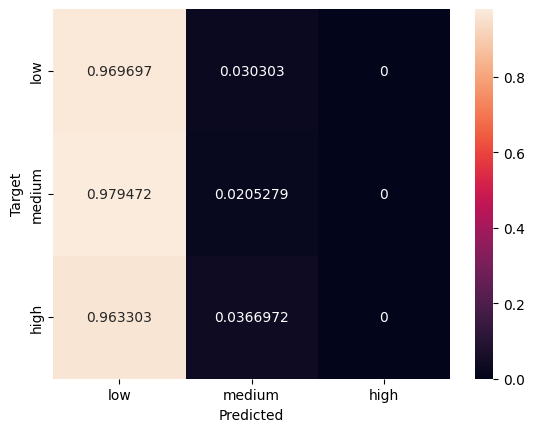

In [110]:
# The Confusion Matrix
def plot_cm(cm):
  classes = ['low', 'medium', 'high']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(valid_data['test']['label'], test_preds, normalize='true')
plot_cm(cm)

## END